In [85]:
import os
import anndata
import anndata as ad
from pathlib import Path
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from scipy.stats import norm

# Loading data

In [2]:
x_hat_s = anndata.read_h5ad(Path(os.getcwd()).parents[0] / "data" / "processed" / "mouse1_slice153_x_hat_s.h5ad")


# Method
## Calculate Ligand and Receptor score

For each ligand (receptor) _g_ in cluster _k_, we compute a score $S(g,k)\in [0,1]$ aimed at measuring how much the observed ligand (receptor) average expression level $\bar{X}_{g}^{k}$ is high compared to the average expression levels observable by ranche for random genes in the same cluster _k_. The distribution of average gene expression level observable by chance was obtained, using a permutation approach, as follows:
i) randomly permuting row/genes in matrix $X^k$ independently for each column/cell;
ii) computing the average genes expression levels in such shuffled version of $X^{k}$;
iii) iterating steps (i) and (ii) multiple times.

In [3]:
import liana as li
lr_df = li.resource.select_resource("mouseconsensus")
lr_df["ligand"]=lr_df["ligand"].str.lower()
lr_df["receptor"]=lr_df["receptor"].str.lower()

## Calculate Ligand and Receptor Pair Score

In [4]:
lr_df

,ligand,receptor
31371,dll1,notch1
31372,dll1,notch2
31373,dll1,notch4
31374,dll1,notch3
31375,nrg2,erbb2_erbb3
...,...,...
35355,serpina1a,lrp1
35356,serpina1b,lrp1
35357,serpina1c,lrp1
35358,serpina1d,lrp1


In [107]:
def compute_gene_cluster_stats(adata, cluster_key="@label", verbose: int = 0):
    if verbose == 1 | verbose == 2:
        print(f"Starting score calculation for {len(adata.obs[cluster_key].unique())} clusters")
    clusters = adata.obs[cluster_key].cat.categories
    cluster_stats = {}
    for cluster in clusters:
        if verbose == 1 | verbose == 2:
            print(f"\nProcessing cluster: {cluster}")
        cell_mask = adata.obs[cluster_key] == cluster
        cluster_data = adata[cell_mask].X
        cluster_stats[cluster] = {
            "mu": np.mean(cluster_data, axis=None),
            "sd": np.std(cluster_data, axis=None),
            "counts": cluster_data.shape[0]
        }
        gene_means = np.mean(cluster_data, axis=0)
        gene_scores = norm.cdf(gene_means, loc=cluster_stats[cluster]["mu"],
                               scale=cluster_stats[cluster]["sd"] / np.sqrt(cluster_stats[cluster]["counts"]))
        gene_scores[gene_means == 0] = 0
        score_key = f'score_{cluster}'
        adata.var[score_key] = gene_scores

    return adata


def prepare_lr_data(adata, lr_pairs_df, verbose: int = 0):
    # First, identify complex molecules
    lr_pairs_df["is_ligand_complex"] = lr_pairs_df["ligand"].str.contains("_")
    lr_pairs_df["ligand_complex_components"] = lr_pairs_df["ligand"].str.split("_")
    lr_pairs_df["is_receptor_complex"] = lr_pairs_df["receptor"].str.contains("_")
    lr_pairs_df["receptor_complex_components"] = lr_pairs_df["receptor"].str.split("_")
    lr_pairs_df["is_interaction_complex"] = lr_pairs_df["is_ligand_complex"] | lr_pairs_df["is_receptor_complex"]

    # Get all unique components
    ligands = set(lr_pairs_df["ligand_complex_components"].explode())
    receptors = set(lr_pairs_df["receptor_complex_components"].explode())

    # Find which components exist in adata
    valid_ligands = ligands.intersection(adata.var_names)
    valid_receptors = receptors.intersection(adata.var_names)

    # Filter lr_pairs_df to keep only pairs where all components exist in adata
    valid_pairs_mask = lr_pairs_df.apply(
        lambda row: all(comp in valid_ligands for comp in row["ligand_complex_components"]) and
                   all(comp in valid_receptors for comp in row["receptor_complex_components"]),
        axis=1
    )

    lr_pairs_df = lr_pairs_df[valid_pairs_mask].copy()

    # Update adata to keep only genes that are part of valid pairs
    all_valid_genes = valid_ligands.union(valid_receptors)
    adata = adata[:, adata.var_names.isin(all_valid_genes)].copy()

    if verbose:
        print(f"Filtered from {len(ligands.union(receptors))} to {len(all_valid_genes)} total genes")
        print(f"Filtered from {len(valid_pairs_mask)} to {valid_pairs_mask.sum()} valid L-R pairs")

    return adata, lr_pairs_df

In the given code cell, there are two major issues:

1. The `len()` function is incorrectly used with pandas Series string methods. When checking for complex ligands/receptors, it should be applied to the result of the split operation, not to the Series itself.

2. There's incomplete and inconsistent code in `compute_lr_scores` function.

Here's the corrected code for the cell:



In [86]:

def compute_lr_scores(adata, lr_pairs_df: pd.DataFrame, cluster_key="@label", verbose: int = 0):
    # Create base L-R pairs first (more efficient)
    lr_pairs = lr_pairs_df["ligand"] + "&" + lr_pairs_df["receptor"]
    clusters = adata.obs[cluster_key].astype("category").cat.categories

    # Create all combinations
    interactions = [
        f"{lr}&{source}&{target}"
        for lr in lr_pairs
        for source in clusters
        for target in clusters
    ]

    # Create DataFrame with ordered interactions
    lr_scores = pd.DataFrame(
        [x.split('&') for x in interactions],
        columns=['ligand', 'receptor', 'source', 'target'],
        index=interactions
    )
    lr_scores['is_ligand_complex'] = lr_scores['ligand'].str.contains("_")
    lr_scores['is_receptor_complex'] = lr_scores['receptor'].str.contains("_")
    lr_scores["ligand_score"] = np.zeros(len(lr_scores))
    lr_scores["receptor_score"] = np.zeros(len(lr_scores))

    def compute_complex_score(adata, complex_molecule: str, cluster_score_key: str) -> float:
        components = complex_molecule.split("_")
        component_scores = adata.var.loc[components, cluster_score_key].values
        complex_score = np.exp(np.mean(np.log(component_scores)))
        return complex_score

    for i, row in tqdm(enumerate(lr_scores.itertuples()), total=len(lr_scores), disable=verbose != 2, desc="Calculating L-R scores"):
        # print(f"Processing interaction {row}")
        if row.is_ligand_complex:
            lr_scores.loc[row[0],"ligand_score"] = compute_complex_score(adata, row.ligand, f"score_{row.source}")
        else:
            lr_scores.loc[row[0],"ligand_score"] = adata.var.loc[row.ligand,f"score_{row.source}"]
        if row.is_receptor_complex:
            lr_scores.loc[row[0],"receptor_score"] = compute_complex_score(adata, row.receptor, f"score_{row.target}")
        else:
            lr_scores.loc[row[0],"receptor_score"] = adata.var.loc[row.receptor, f"score_{row.target}"]
        # print(f"Processed interaction to {lr_scores.loc[row[0]]}")
    lr_scores["score"] = np.minimum(lr_scores["ligand_score"], lr_scores["receptor_score"])

    return lr_scores

In [108]:
adata = x_hat_s.copy()
adata, complex_info = prepare_lr_data(adata, lr_df)
adata = compute_gene_cluster_stats(adata, cluster_key='subclass', verbose=2)

In [109]:
print("tnfsf12" in adata.var_names)
print("tnfsf12" in lr_df.ligand)
print("tnfsf12" in lr_df.receptor)
print("tnfsf12" in complex_info["ligand_complex_components"].explode().unique())
print("tnfsf12" in complex_info["receptor_complex_components"].explode().unique())

False
False
False
False
False


In [110]:
lr_scores = compute_lr_scores(adata, complex_info, cluster_key='subclass', verbose=2)
# print(adata, complex_info)

# print(adata)


Calculating L-R scores: 100%|██████████| 2088000/2088000 [11:33<00:00, 3009.06it/s]


In [111]:
lr_scores.to_csv(
    Path(os.getcwd()).parents[0] / "data" / "processed" / "mouse1_slice153_lr_inter_scores.csv")

In [121]:
# select top 3 lr pairs between clusters ASTRO and L2/3 IT
source = "Astro"
target = "L2/3 IT"
df = lr_scores.query(f"source == '{source}' & target == '{target}'")
df.sort_values(by="score", ascending=False).head(10)

,ligand,receptor,source,target,is_ligand_complex,is_receptor_complex,ligand_score,receptor_score,score
gnai2&cnr1&Astro&L2/3 IT,gnai2,cnr1,Astro,L2/3 IT,False,False,1.0,1.0,1.0
gnai2&oprm1&Astro&L2/3 IT,gnai2,oprm1,Astro,L2/3 IT,False,False,1.0,1.0,1.0
arf1&insr&Astro&L2/3 IT,arf1,insr,Astro,L2/3 IT,False,False,1.0,1.0,1.0
fstl1&dip2a&Astro&L2/3 IT,fstl1,dip2a,Astro,L2/3 IT,False,False,1.0,1.0,1.0
rtn4&rtn4r&Astro&L2/3 IT,rtn4,rtn4r,Astro,L2/3 IT,False,False,1.0,1.0,1.0
gnai2&adcy1&Astro&L2/3 IT,gnai2,adcy1,Astro,L2/3 IT,False,False,1.0,1.0,1.0
rtn4&lingo1&Astro&L2/3 IT,rtn4,lingo1,Astro,L2/3 IT,False,False,1.0,1.0,1.0
apoe&sorl1&Astro&L2/3 IT,apoe,sorl1,Astro,L2/3 IT,False,False,1.0,1.0,1.0
rtn4&tnfrsf19&Astro&L2/3 IT,rtn4,tnfrsf19,Astro,L2/3 IT,False,False,1.0,1.0,1.0
bsg&slc16a7&Astro&L2/3 IT,bsg,slc16a7,Astro,L2/3 IT,False,False,1.0,1.0,1.0


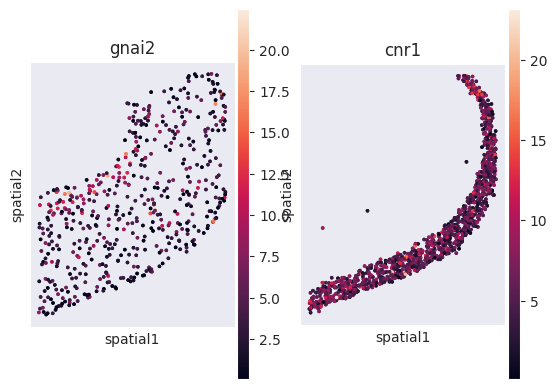

In [120]:
import matplotlib.pyplot as plt
import squidpy as sq
fig, axs = plt.subplots(ncols = 2)
axs = axs.flatten()
adata.obsm["spatial"] = np.array([(x,y) for x,y in zip(adata.obs["centroid_x"], adata.obs["centroid_y"])])
features = ["gnai2","cnr1"]
groups = [source, target]
for i,ax in enumerate(axs):
    sq.pl.spatial_scatter(
        adata[(adata.obs["subclass"] == groups[i]),:],
        color = features[i],
        shape=None,
        size=10,
        ax=ax,
    )

<Axes: ylabel='score_Astro'>

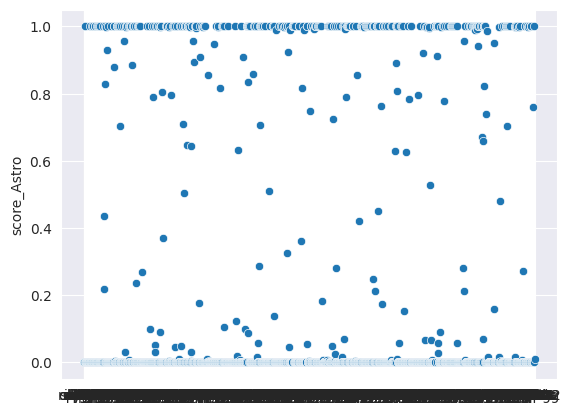

In [25]:
import seaborn as sns
sns.scatterplot(adata.var["score_Astro"])

In [16]:

import matplotlib.pyplot as plt
import seaborn as sns

def plot_score_distributions(adata, n_cols=3, figsize=(15, 10)):
    """
    Plot histograms of score distributions for each subclass,
    separated by ligands and receptors.

    Parameters
    ----------
    adata : AnnData
        Annotated data matrix with scores calculated
    n_cols : int
        Number of columns in the subplot grid
    figsize : tuple
        Figure size (width, height)
    """
    # Get score columns
    score_cols = [col for col in adata.var.columns if col.startswith('score_')]

    # Calculate number of rows needed
    n_rows = (len(score_cols) + n_cols - 1) // n_cols

    # Create figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    if n_rows == 1:
        axes = axes.reshape(1, -1)

    # Flatten axes for easier iteration
    axes = axes.flatten()

    # Plot histograms
    for idx, score_col in enumerate(score_cols):
        ax = axes[idx]

        # Get scores for ligands and receptors
        ligand_scores = adata.var[adata.var['type'] == 'ligand'][score_col]
        receptor_scores = adata.var[adata.var['type'] == 'receptor'][score_col]

        # Plot histograms
        sns.histplot(data=ligand_scores, ax=ax, alpha=0.5, label='Ligands',
                    bins=30, color='blue')
        sns.histplot(data=receptor_scores, ax=ax, alpha=0.5, label='Receptors',
                    bins=30, color='red')

        # Customize plot
        ax.set_title(score_col.replace('score_', ''))
        ax.set_xlabel('Score')
        ax.set_ylabel('Count')
        ax.legend()

        # Add mean lines
        ax.axvline(ligand_scores.mean(), color='blue', linestyle='--', alpha=0.5)
        ax.axvline(receptor_scores.mean(), color='red', linestyle='--', alpha=0.5)

    # Remove empty subplots if any
    for idx in range(len(score_cols), len(axes)):
        fig.delaxes(axes[idx])

    # Adjust layout
    plt.tight_layout()
    return fig

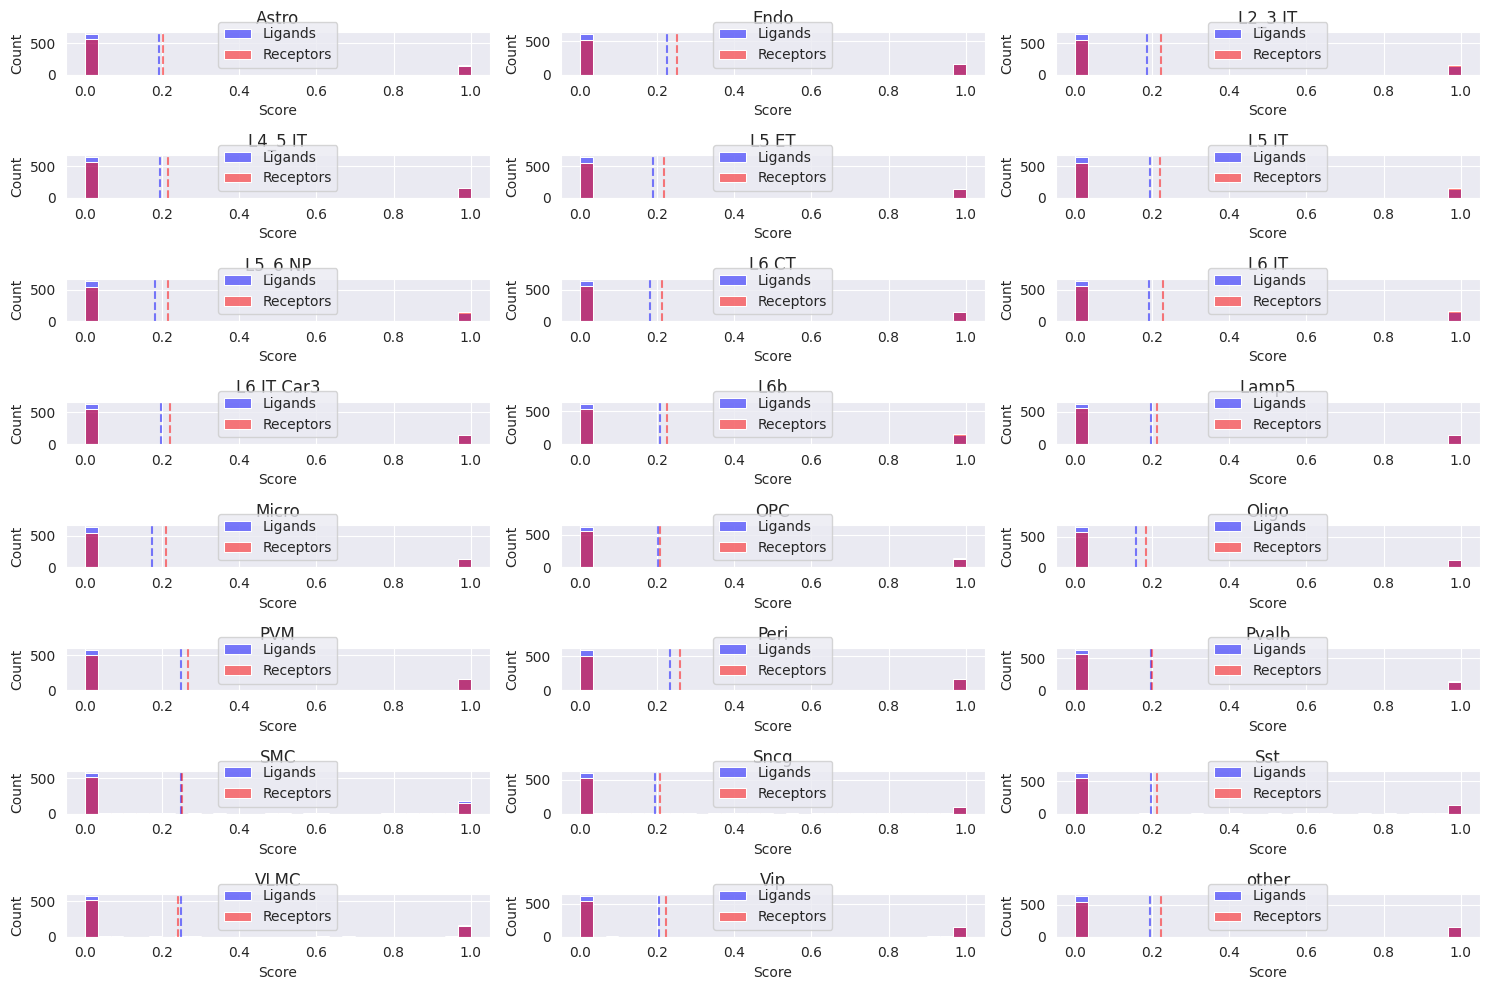


Summary Statistics:

score_Astro:
Ligands:
  Mean: 0.193
  Median: 0.000
  Std: 0.392
Receptors:
  Mean: 0.201
  Median: 0.000
  Std: 0.397

score_Endo:
Ligands:
  Mean: 0.225
  Median: 0.000
  Std: 0.411
Receptors:
  Mean: 0.253
  Median: 0.000
  Std: 0.429

score_L2_3 IT:
Ligands:
  Mean: 0.188
  Median: 0.000
  Std: 0.389
Receptors:
  Mean: 0.224
  Median: 0.000
  Std: 0.415

score_L4_5 IT:
Ligands:
  Mean: 0.196
  Median: 0.000
  Std: 0.395
Receptors:
  Mean: 0.215
  Median: 0.000
  Std: 0.410

score_L5 ET:
Ligands:
  Mean: 0.190
  Median: 0.000
  Std: 0.388
Receptors:
  Mean: 0.218
  Median: 0.000
  Std: 0.407

score_L5 IT:
Ligands:
  Mean: 0.195
  Median: 0.000
  Std: 0.393
Receptors:
  Mean: 0.221
  Median: 0.000
  Std: 0.413

score_L5_6 NP:
Ligands:
  Mean: 0.181
  Median: 0.000
  Std: 0.380
Receptors:
  Mean: 0.217
  Median: 0.000
  Std: 0.404

score_L6 CT:
Ligands:
  Mean: 0.183
  Median: 0.000
  Std: 0.384
Receptors:
  Mean: 0.213
  Median: 0.000
  Std: 0.408

score_L6 IT:


In [17]:

# Example usage:
fig = plot_score_distributions(x_f)
plt.show()


## Calculate TF activity

## Calculate Intracellular score